# Import dataset 

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('rideshare_kaggle.csv')

#print the dataset
data[0:5]

,id,timestamp,hour,day,month,datetime,timezone,source,destination,cab_type,...,precipIntensityMax,uvIndexTime,temperatureMin,temperatureMinTime,temperatureMax,temperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime
0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,1.544953e+09,9,16,12,2018-12-16 09:30:07,America/New_York,Haymarket Square,North Station,Lyft,...,0.1276,1544979600,39.89,1545012000,43.68,1544968800,33.73,1545012000,38.07,1544958000
1,4bd23055-6827-41c6-b23b-3c491f24e74d,1.543284e+09,2,27,11,2018-11-27 02:00:23,America/New_York,Haymarket Square,North Station,Lyft,...,0.1300,1543251600,40.49,1543233600,47.30,1543251600,36.20,1543291200,43.92,1543251600
2,981a3613-77af-4620-a42a-0c0866077d1e,1.543367e+09,1,28,11,2018-11-28 01:00:22,America/New_York,Haymarket Square,North Station,Lyft,...,0.1064,1543338000,35.36,1543377600,47.55,1543320000,31.04,1543377600,44.12,1543320000
3,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,1.543554e+09,4,30,11,2018-11-30 04:53:02,America/New_York,Haymarket Square,North Station,Lyft,...,0.0000,1543507200,34.67,1543550400,45.03,1543510800,30.30,1543550400,38.53,1543510800
4,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,1.543463e+09,3,29,11,2018-11-29 03:49:20,America/New_York,Haymarket Square,North Station,Lyft,...,0.0001,1543420800,33.10,1543402800,42.18,1543420800,29.11,1543392000,35.75,1543420800


In [21]:
# Overview

print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693071 entries, 0 to 693070
Data columns (total 57 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           693071 non-null  object 
 1   timestamp                    693071 non-null  float64
 2   hour                         693071 non-null  int64  
 3   day                          693071 non-null  int64  
 4   month                        693071 non-null  int64  
 5   datetime                     693071 non-null  object 
 6   timezone                     693071 non-null  object 
 7   source                       693071 non-null  object 
 8   destination                  693071 non-null  object 
 9   cab_type                     693071 non-null  object 
 10  product_id                   693071 non-null  object 
 11  name                         693071 non-null  object 
 12  price                        637976 non-null  float64
 13 

In [22]:
#Check if there are any null values
missing_values = data.isnull().sum()
print(missing_values)

id                                 0
timestamp                          0
hour                               0
day                                0
month                              0
datetime                           0
timezone                           0
source                             0
destination                        0
cab_type                           0
product_id                         0
name                               0
price                          55095
distance                           0
surge_multiplier                   0
latitude                           0
longitude                          0
temperature                        0
apparentTemperature                0
short_summary                      0
long_summary                       0
precipIntensity                    0
precipProbability                  0
humidity                           0
windSpeed                          0
windGust                           0
windGustTime                       0
v

there are 55095 null values in price


In [32]:
# Check duplicates
duplicates = data.duplicated().sum()

print(duplicates)

0


## Price is our Target variable 

In [23]:
#Load prices into variable
prices = data['price']
#Print description
print(prices.describe())

count    637976.000000
mean         16.545125
std           9.324359
min           2.500000
25%           9.000000
50%          13.500000
75%          22.500000
max          97.500000
Name: price, dtype: float64


Text(0, 0.5, 'Occurences')

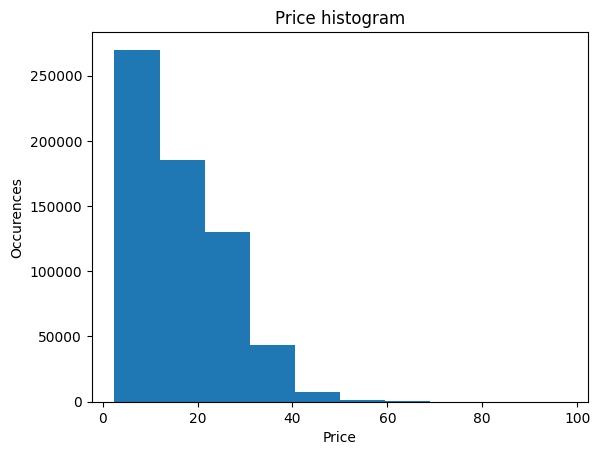

In [ ]:
#make a histogram

plt.hist(prices)
plt.title('Price histogram')
plt.xlabel('Price')
plt.ylabel('Occurences')

In [ ]:
#Separate Uber and Lyft in two variables

uber_data = data[data['cab_type'] == 'Uber']
lyft_data = data[data['cab_type'] == 'Lyft']

# Overview

print(uber_data.info())


#print(lyft_data.info())

# The data set is well divided, we have half of the values by uber and half by lyft

<class 'pandas.core.frame.DataFrame'>
Index: 385663 entries, 12 to 693070
Data columns (total 57 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           385663 non-null  object 
 1   timestamp                    385663 non-null  float64
 2   hour                         385663 non-null  int64  
 3   day                          385663 non-null  int64  
 4   month                        385663 non-null  int64  
 5   datetime                     385663 non-null  object 
 6   timezone                     385663 non-null  object 
 7   source                       385663 non-null  object 
 8   destination                  385663 non-null  object 
 9   cab_type                     385663 non-null  object 
 10  product_id                   385663 non-null  object 
 11  name                         385663 non-null  object 
 12  price                        330568 non-null  float64
 13  dis

In [58]:
print("UBER")
print(uber_data["surge_multiplier"].mean())
print(uber_data["surge_multiplier"].median())

print("LYFT")
print(lyft_data["surge_multiplier"].mean())
print(lyft_data["surge_multiplier"].median())

UBER
1.0
1.0
LYFT
1.0312703312861085
1.0


Uber does not use surge multiplier, so they are all 1, but lyft uses. We need to remove the column maybe...

### Trying to compare the target variable with other variables

Scaterplot


C:\Users\ligia\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


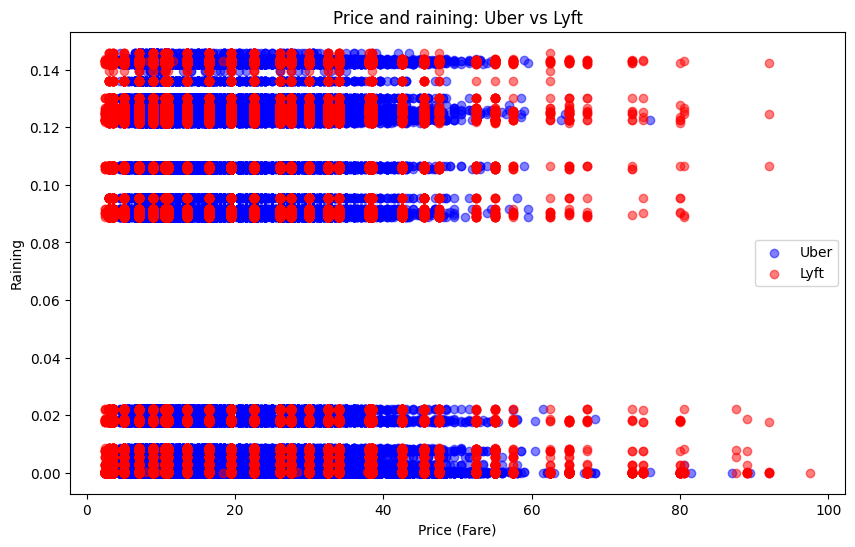

In [ ]:


# Compare price and precipIntensityMax
plt.figure(figsize=(10, 6))
plt.scatter(uber_data['price'], uber_data['precipIntensityMax'], color='blue', alpha=0.5, label='Uber')
plt.scatter(lyft_data['price'], lyft_data['precipIntensityMax'], color='red', alpha=0.5, label='Lyft')

plt.xlabel('Price (Fare)')
plt.ylabel('Raining')
plt.title('Price and raining: Uber vs Lyft')
plt.legend()
plt.show()

Apparently, rain does not afect that much....

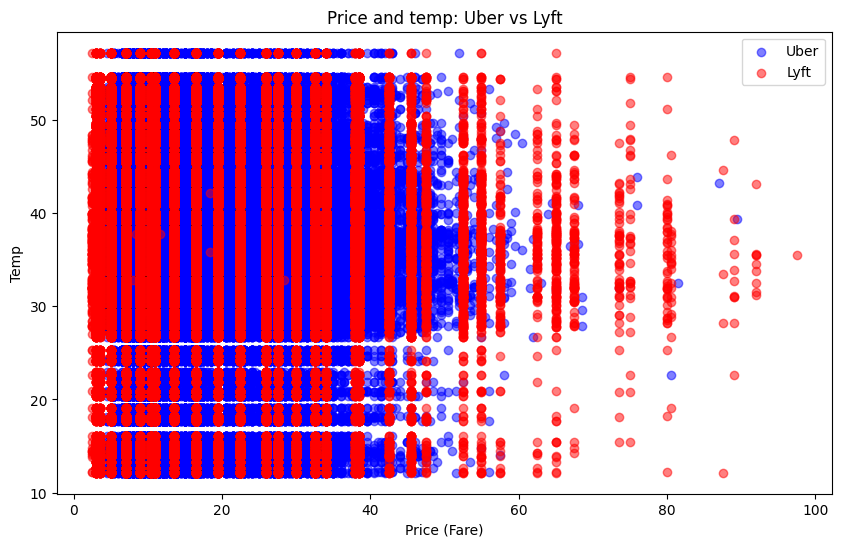

In [26]:
# Compare price and Temperature
plt.figure(figsize=(10, 6))
plt.scatter(uber_data['price'], uber_data['apparentTemperature'], color='blue', alpha=0.5, label='Uber')
plt.scatter(lyft_data['price'], lyft_data['apparentTemperature'], color='red', alpha=0.5, label='Lyft')

plt.xlabel('Price (Fare)')
plt.ylabel('Temp')
plt.title('Price and temp: Uber vs Lyft')
plt.legend()
plt.show()

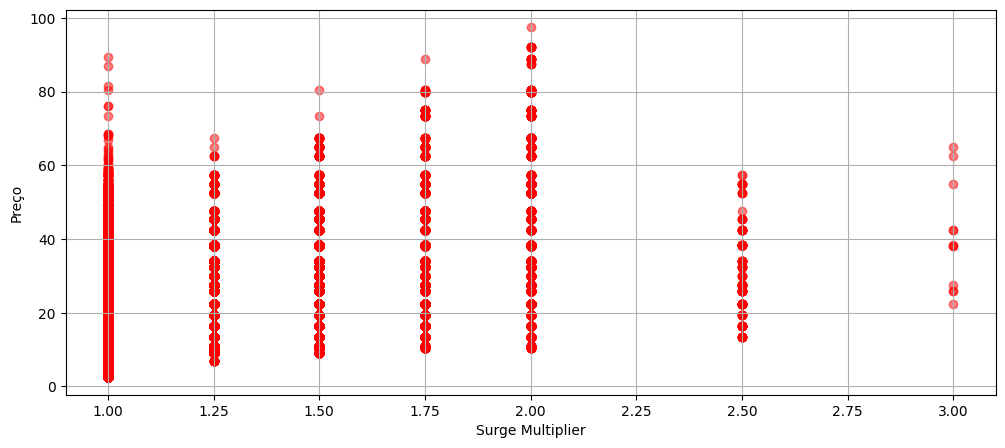

In [43]:
# scatter plot 'price' vs 'surge_multiplier'
plt.figure(figsize=(12, 5))
plt.scatter(data["surge_multiplier"], data["price"], alpha=0.5, color="red")
plt.xlabel("Surge Multiplier")
plt.ylabel("Preço")
plt.grid(True)
plt.show()

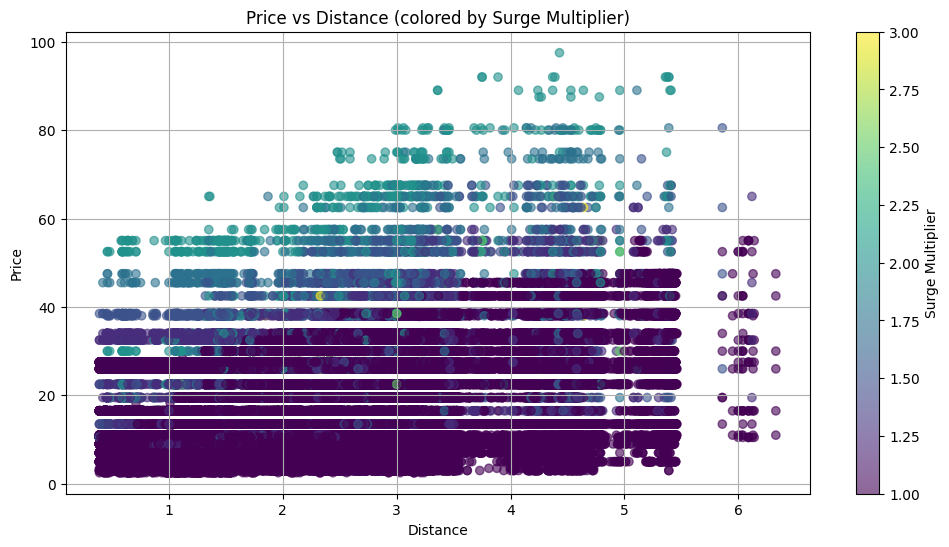

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Scatter plot com cores indicando surge multiplier
scatter = plt.scatter(
    lyft_data["distance"],
    lyft_data["price"],
    c=lyft_data["surge_multiplier"],
    cmap='viridis',
    alpha=0.6
)

# Barra de cores indicando surge multiplier
plt.colorbar(scatter, label='Surge Multiplier')

plt.xlabel("Distance")
plt.ylabel("Price")
plt.title("Price vs Distance (colored by Surge Multiplier)")
plt.grid(True)

plt.show()



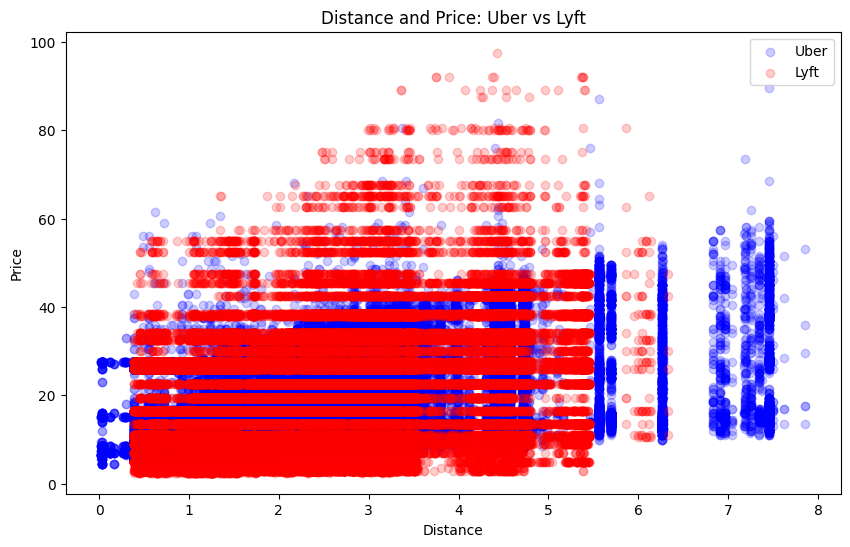

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(uber_data['distance'], uber_data['price'], color='blue', alpha=0.2 , label='Uber')
plt.scatter(lyft_data['distance'], lyft_data['price'], color='red', alpha=0.2, label='Lyft')

# I used ALPHA 0.2 to let the dots with 20% of opacity so we can see it better

plt.xlabel('Distance')
plt.ylabel('Price')
plt.title('Distance and Price: Uber vs Lyft')
plt.legend()
plt.show()

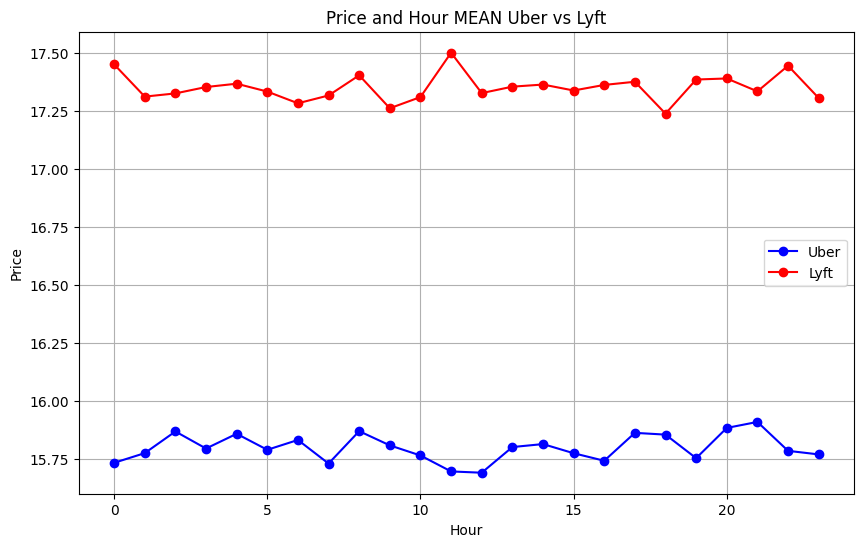

In [38]:
# Calcular média de preço por hora para cada serviço
uber_avg_price = uber_data.groupby('hour')['price'].mean()
lyft_avg_price = lyft_data.groupby('hour')['price'].mean()

# Criar gráfico de linha
plt.figure(figsize=(10, 6))
plt.plot(uber_avg_price.index, uber_avg_price.values, color='blue', marker='o', label='Uber')
plt.plot(lyft_avg_price.index, lyft_avg_price.values, color='red', marker='o', label='Lyft')

plt.xlabel('Hour')
plt.ylabel('Price')
plt.title('Price and Hour MEAN Uber vs Lyft')
plt.legend()
plt.grid(True)
plt.show()


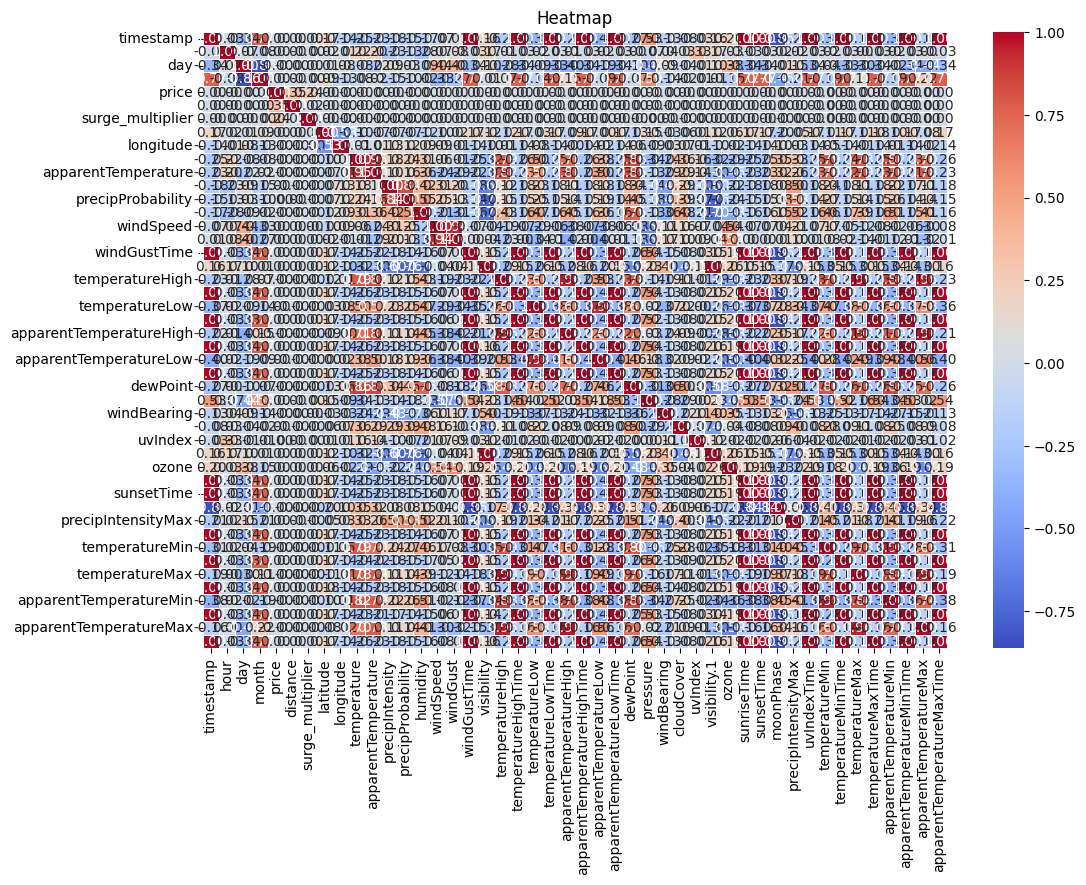

In [39]:
import seaborn as sns

# Select ONLY NUMERIC DATA
numeric_data = data.select_dtypes(include=['float64', 'int64'])

# Correlation matrix
correlation_matrix = numeric_data.corr()

# Create heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

plt.title('Heatmap')
plt.show()


In [ ]:
id,"timestamp","hour","day","month","datetime","timezone",
"source","destination","cab_type","product_id","name","price","distance",
"surge_multiplier","latitude","longitude","temperature","apparentTemperature",
"short_summary","long_summary","precipIntensity","precipProbability","humidity",
"windSpeed","windGust","windGustTime","visibility","temperatureHigh","temperatureHighTime",
"temperatureLow","temperatureLowTime","apparentTemperatureHigh","apparentTemperatureHighTime",
"apparentTemperatureLow","apparentTemperatureLowTime","icon","dewPoint","pressure","windBearing",
"cloudCover","uvIndex","visibility.1","ozone","sunriseTime","sunsetTime","moonPhase","precipIntensityMax",
"uvIndexTime","temperatureMin","temperatureMinTime","temperatureMax","temperatureMaxTime","apparentTemperatureMin",
"apparentTemperatureMinTime","apparentTemperatureMax","apparentTemperatureMaxTime"


timestamp
datetime
timezone
long_summary
precipIntensity
temperatureLow	
temperatureLowTime
apparentTemperatureHigh	
apparentTemperatureHighTime	
apparentTemperatureLow	
apparentTemperatureLowTime	
icon


SyntaxError: invalid syntax (310356858.py, line 19)

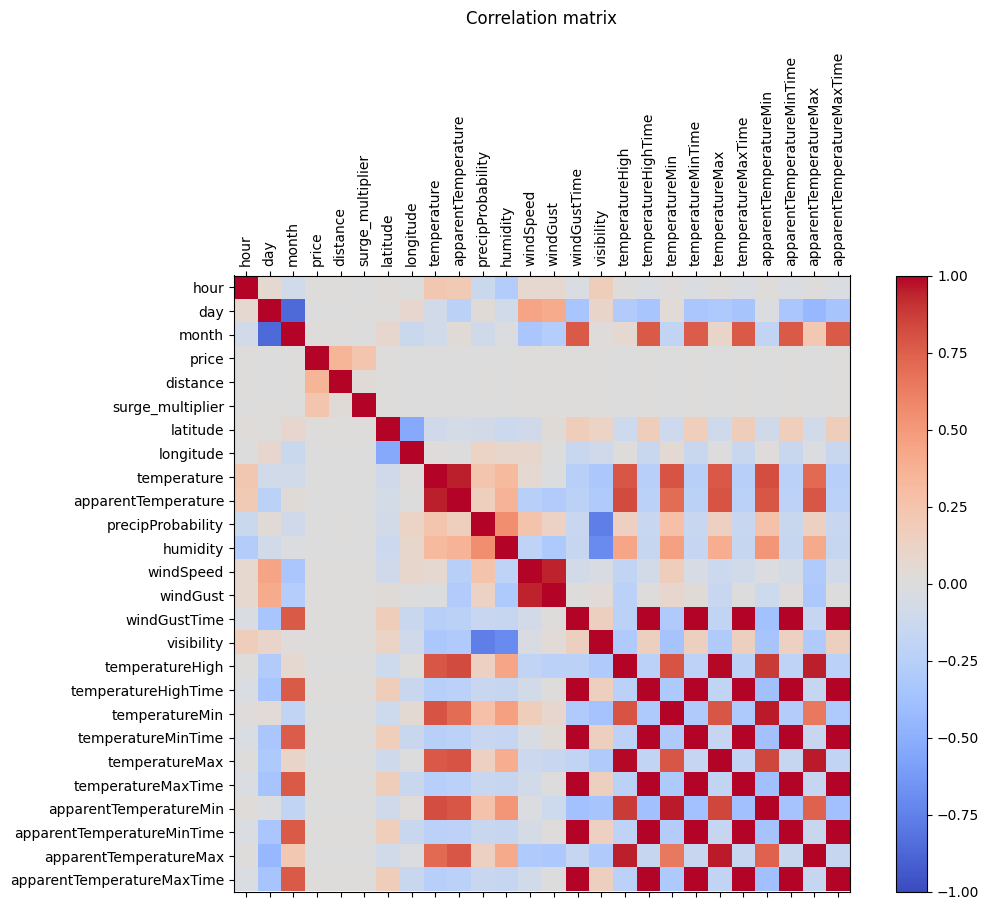

In [ ]:
# I will try to remove some colums to make it easier to see
columns_to_remove = [
    "timestamp", "datetime", "timezone", "long_summary", "precipIntensity",
    "temperatureLow", "temperatureLowTime", "apparentTemperatureHigh", "apparentTemperatureHighTime",
    "apparentTemperatureLow", "apparentTemperatureLowTime", "icon", "dewPoint", "pressure",
    "windBearing", "cloudCover", "uvIndex", "visibility.1", "ozone", "sunriseTime", 
    "sunsetTime", "moonPhase", "precipIntensityMax", "uvIndexTime"
]

data_cleaned = data.drop(columns=[col for col in columns_to_remove if col in data.columns])

# Select ONLY NUMERIC DATA
numeric_data = data_cleaned.select_dtypes(include=['float64', 'int64'])

# calculate correlation matrix
correlation_matrix = numeric_data.corr()

# create using matplotlib
fig, ax = plt.subplots(figsize=(12, 8))
cax = ax.matshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)

# Adicionar barra de cores
fig.colorbar(cax)

# Definir rótulos dos eixos
ax.set_xticks(np.arange(len(correlation_matrix.columns)))
ax.set_yticks(np.arange(len(correlation_matrix.columns)))
ax.set_xticklabels(correlation_matrix.columns, rotation=90)
ax.set_yticklabels(correlation_matrix.columns)

# Título
plt.title('Correlation matrix', pad=20)

# Exibir o gráfico
plt.show()


In [ ]:
file_path = "rideshare_kaggle.csv"
data = pd.read_csv(file_path)


# Selecionar apenas colunas numéricas
numeric_data = data.select_dtypes(include=['float64', 'int64'])

# Calcular matriz de correlação
correlation_matrix = numeric_data.corr()

correlation_matrix


,timestamp,hour,day,month,price,distance,surge_multiplier,latitude,longitude,temperature,...,precipIntensityMax,uvIndexTime,temperatureMin,temperatureMinTime,temperatureMax,temperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime
timestamp,1.000000,-0.028004,-0.341292,0.771182,0.000808,0.003553,0.000572,0.168130,-0.136802,-0.248748,...,-0.211700,0.999364,-0.306971,0.998194,-0.186328,0.999290,-0.378346,0.998286,-0.157748,0.999276
hour,-0.028004,1.000000,0.066090,-0.079379,0.000561,0.002280,-0.000077,0.019493,-0.006295,0.218769,...,0.019940,-0.027518,0.015513,-0.027027,0.002958,-0.027990,0.015820,-0.027704,0.002897,-0.027785
day,-0.341292,0.066090,1.000000,-0.861306,-0.000722,-0.000627,0.001389,0.006838,0.078690,-0.084116,...,0.145568,-0.341198,0.038076,-0.333990,-0.304870,-0.344532,-0.019940,-0.335043,-0.444445,-0.344411
month,0.771182,-0.079379,-0.861306,1.000000,0.000913,0.002298,-0.000628,0.085791,-0.126912,-0.081774,...,-0.213054,0.770767,-0.191803,0.765255,0.105326,0.772989,-0.191153,0.766031,0.215076,0.772896
price,0.000808,0.000561,-0.000722,0.000913,1.000000,0.345061,0.240458,0.002088,-0.001417,-0.000084,...,0.001114,0.000763,-0.000428,0.000769,-0.000550,0.000766,-0.000580,0.000814,-0.000290,0.000746
distance,0.003553,0.002280,-0.000627,0.002298,0.345061,1.000000,0.024769,0.000819,-0.000293,-0.002884,...,0.000648,0.003562,-0.003396,0.003428,-0.004191,0.003580,-0.003937,0.003526,-0.004238,0.003584
surge_multiplier,0.000572,-0.000077,0.001389,-0.000628,0.240458,0.024769,1.000000,0.001375,-0.001829,-0.001572,...,-0.000101,0.000544,-0.000724,0.000554,-0.001951,0.000522,-0.001304,0.000464,-0.002154,0.000519
latitude,0.168130,0.019493,0.006838,0.085791,0.002088,0.000819,0.001375,1.000000,-0.531259,-0.098604,...,-0.047535,0.171820,-0.114185,0.169592,-0.108953,0.175177,-0.096084,0.170921,-0.082600,0.173206
longitude,-0.136802,-0.006295,0.078690,-0.126912,-0.001417,-0.000293,-0.001829,-0.531259,1.000000,0.012183,...,0.030753,-0.136724,0.048723,-0.140403,-0.007274,-0.137041,0.010138,-0.140518,-0.022854,-0.135621
temperature,-0.248748,0.218769,-0.084116,-0.081774,-0.000084,-0.002884,-0.001572,-0.098604,0.012183,1.000000,...,0.333081,-0.254467,0.789261,-0.242698,0.780546,-0.253881,0.817521,-0.231513,0.703208,-0.255288
